In [18]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
import os 


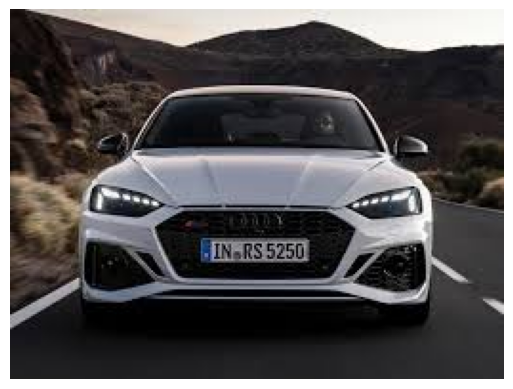

In [19]:
img = mpimg.imread('/kaggle/input/cars-image-dataset/Cars Dataset/train/Audi/1001.jpg')
plt.imshow(img)
plt.axis('off') 
plt.show()


## **Reading Image from floders (Dataset)**

In [20]:
train_dir = '/kaggle/input/cars-image-dataset/Cars Dataset/train/'
test_dir = '/kaggle/input/cars-image-dataset/Cars Dataset/test/'

IMG_SIZE = 224 

def read_dataset(folder_path):
    images = []
    labels = []


    for class_folder in tqdm(os.listdir(folder_path)):

        # print("class folder ",class_folder)
        
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            label = class_folder

            for image_file in os.listdir(class_path):
                
                image_path = os.path.join(class_path, image_file)

                # print("image path ",image_path)

                # Reading the image and converting it to a numpy array
                img = Image.open(image_path).convert('RGB').resize((IMG_SIZE, IMG_SIZE))
                img_array = np.array(img, dtype=np.uint8)

                images.append(img_array)
                labels.append(label)

    return np.array(images), np.array(labels)

train_images, train_labels  = read_dataset(train_dir)
test_images, test_labels  = read_dataset(test_dir)


100%|██████████| 7/7 [00:02<00:00,  2.59it/s]


## **Car Images Visualization**

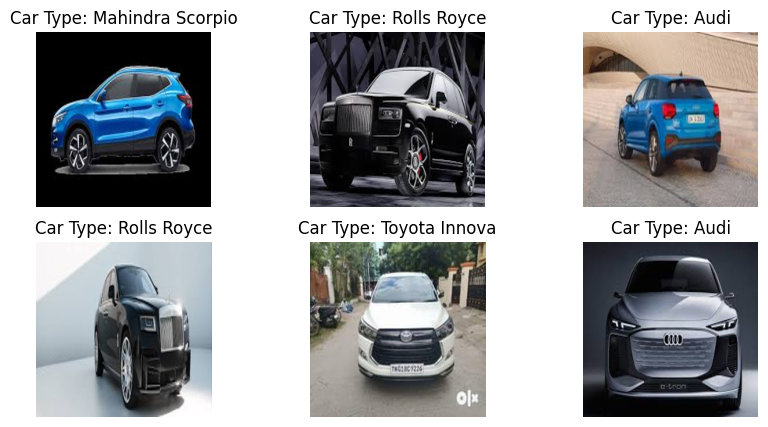

In [21]:
import random

random_indices = random.sample(range(len(train_images)), 6)

plt.figure(figsize=(10, 5))

# Create a grid of subplots
for i, idx in enumerate(random_indices):
    image = train_images[idx]
    plt.subplot(2, 3, i + 1)  # Create a 2x3 grid
    plt.title(f"Car Type: {train_labels[idx]}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")  # Turn off axis for better visualization



## **Data preproccessing**

In [25]:
train_labels = pd.get_dummies(train_labels, columns=['class'])
train_labels= train_labels.astype('int32')
test_labels = pd.get_dummies(test_labels, columns=['class'])
test_labels= test_labels.astype('int32')
# x_train,x_test,y_train,y_test=train_test_split(train_images,labels,test_size=0.20,random_state=42,stratify=labels,shuffle=True)
from sklearn.utils import shuffle

# Shuffle the training data with a fixed random seed
x_train, y_train = shuffle(train_images, train_labels, random_state=42)

# Shuffle the test data with the same random seed (if required)
x_test, y_test = shuffle(test_images, test_labels, random_state=42)

## **Densnet Arcticture Model**

In [28]:
densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model (optional if fine-tuning is not required)
densenet.trainable = False

for layer in densenet.layers[-100:]:
    layer.trainable = True

early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=2, restore_best_weights=True)

In [29]:
# Build the model
from tensorflow.keras.optimizers import Adam
DenseModel = models.Sequential([
    densenet,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])



DenseModel.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [30]:
DenseHistory = DenseModel.fit(
    
    x_train,y_train,
    validation_split=0.2,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 81s 531ms/step - accuracy: 0.3977 - loss: 1.6858 - val_accuracy: 0.4784 - val_loss: 1.6416
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.7273 - loss: 0.8184 - val_accuracy: 0.6587 - val_loss: 1.1562
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step - accuracy: 0.8357 - loss: 0.4788 - val_accuracy: 0.7154 - val_loss: 1.1044
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.9023 - loss: 0.3062 - val_accuracy: 0.7511 - val_loss: 0.9139
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - accuracy: 0.9328 - loss: 0.1987 - val_accuracy: 0.7496 - val_loss: 0.8026
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.9541 - loss: 0.1529 - val_accuracy: 0.7705 - val_loss: 0.9059
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9357 - loss: 0.1807 - val_accuracy: 0.7243 - val_loss: 1.4370
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.9646 - loss: 0.1162 - val_acc

In [31]:
loss, accuracy = DenseModel.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - accuracy: 0.8839 - loss: 0.6105
Test accuracy: 0.876998782157898


## **Xception Arcticture Model**

In [32]:
from tensorflow.keras.applications import Xception

xception = Xception(weights='imagenet', include_top=False)

xception.trainable = False

for layer in xception.layers[-100:]:
    layer.trainable = True



In [33]:
XceptionModel = models.Sequential([
    xception,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(7, activation='softmax')
])



In [34]:
XceptionModel.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [35]:
XceptionHistory = XceptionModel.fit(
    
    x_train,y_train,
    validation_split=0.1,
    epochs=100,
    callbacks=[early_stopping]
)


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 599ms/step - accuracy: 0.2657 - loss: 1.8784 - val_accuracy: 0.2173 - val_loss: 3.1043
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 33s 343ms/step - accuracy: 0.4533 - loss: 1.4494 - val_accuracy: 0.4940 - val_loss: 1.7221
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 336ms/step - accuracy: 0.6153 - loss: 1.0535 - val_accuracy: 0.2143 - val_loss: 6.1688
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.6935 - loss: 0.8303 - val_accuracy: 0.4792 - val_loss: 1.3119
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.7933 - loss: 0.6221 - val_accuracy: 0.4494 - val_loss: 1.4105
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - accuracy: 0.8270 - loss: 0.5104 - val_accuracy: 0.2381 - val_loss: 3.7253
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 338ms/step - accuracy: 0.8902 - loss: 0.3255 - val_accuracy: 0.4792 - val_loss: 2.4670
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 32s 339ms/step - accuracy: 0.8943 - loss: 0.3241 - 

In [37]:
loss, accuracy = XceptionModel.evaluate(x_test, y_test)
print("Test accuracy:", accuracy)

26/26 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.1954 - loss: 3.2958
Test accuracy: 0.1980319768190384


## **ResNet Architecture Model**

In [38]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam

# Define a function for a Residual Block
def residual_block(filters, downsample=False):
    def block(x):
        shortcut = x

        # Adjust the shortcut connection if downsampling or filter size changes
        if downsample or x.shape[-1] != filters:
            shortcut = layers.Conv2D(filters, (1, 1), strides=(2 if downsample else 1), padding="same")(x)
            shortcut = layers.BatchNormalization()(shortcut)

        x = layers.Conv2D(filters, (3, 3), strides=(2 if downsample else 1), padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Conv2D(filters, (3, 3), padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Add()([x, shortcut])
        x = layers.ReLU()(x)
        return x
    return block

# Define the ResNet model using Sequential
def build_resnet(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Layer
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

    # Residual Blocks
    x = residual_block(64)(x)
    x = residual_block(128, downsample=False)(x)
    x = residual_block(256, downsample=False)(x)

    # Fully Connected Dense Layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)  # Increased dropout rate
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model  

In [39]:
# Build the model
resnet_model = build_resnet((224, 224, 3), num_classes=7)

# Compile the model
resnet_model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)


In [43]:
# Shuffle the training data with a fixed random seed
x_train, y_train = shuffle(x_train, y_train, random_state=41)

resnet_model.fit(
    x_train,y_train,
    validation_split=0.1, 
    epochs=100,
    # callbacks=[early_stopping]
)


Epoch 1/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.9059 - loss: 0.3144 - val_accuracy: 0.4226 - val_loss: 4.2472
Epoch 2/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 161ms/step - accuracy: 0.8951 - loss: 0.2943 - val_accuracy: 0.8006 - val_loss: 0.6240
Epoch 3/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 159ms/step - accuracy: 0.8995 - loss: 0.3253 - val_accuracy: 0.5774 - val_loss: 2.2626
Epoch 4/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 154ms/step - accuracy: 0.8821 - loss: 0.3636 - val_accuracy: 0.8780 - val_loss: 0.3653
Epoch 5/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9141 - loss: 0.2640 - val_accuracy: 0.7976 - val_loss: 0.5537
Epoch 6/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 0.9088 - loss: 0.2451 - val_accuracy: 0.5625 - val_loss: 2.3296
Epoch 7/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 153ms/step - accuracy: 0.9128 - loss: 0.2729 - val_accuracy: 0.5714 - val_loss: 2.7482
Epoch 8/100
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - accuracy: 0.9231 - loss: 0.2365 - 

In [46]:
resnet_model.evaluate(x_test,y_test)[1]

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7759 - loss: 1.2775


0.7798277735710144